<a href="https://colab.research.google.com/github/icsd13152/Sentiment_Analysis_Covid19/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn import feature_extraction, model_selection
# !pip install transformers
from transformers import BertTokenizer,BertModel, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
import tensorflow_datasets as tfds
# !pip install --upgrade tensorflow_hub
import tensorflow_hub as hub
# !pip install tensorflow-text
import nltk
#import tensorflow_text as text
from nltk.corpus import  wordnet
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import shutil
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv(r"/content/drive/My Drive/NLP/Project/Corona_NLP_train.csv",encoding='latin-1')
print(data.head(5))


   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


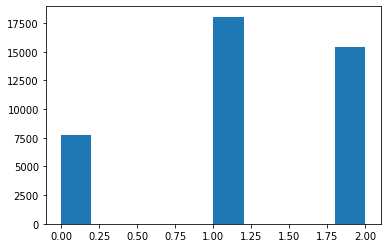

In [ ]:
data["Sentiment"] = data["Sentiment"].replace('Extremely Negative', 'Negative', regex=True)

data["Sentiment"] = data["Sentiment"].replace('Extremely Positive', 'Positive', regex=True)

#transform Sentiment to number
#negative=0
#postive=1
#neutral=2
data["Sentiment"]=data["Sentiment"].replace('Negative', 2, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Positive', 1, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Neutral', 0, regex=True)


plt.hist(data["Sentiment"])
plt.show()

In [ ]:
#short words/apostrophe lookup
contraction_dict1 = {"Â":"","’":"'","Ã":""}
contraction_dict2 = {"Â":"","’":"'","ain't": "are not","'s":" is","aren't": "are not","don't": "do not","Don't":"Do not",
                     "I'll":"I will","Didn't":"Did not","hasn't":"has not","NYC":"New York City","16MAR20":"",
                     "I'd":"I would","I've":"I have","you're":"you are","I'm":"I am","it's":"it is",
                     "#NZ":"","they'll":"they will","they're":"they are","can't":"can not","Y'all":"You All",
                     "I m":"I am","can't":"can not","don t":"do not","I ve":"I have","we're":"we are",
                     "LOL":"lough out loud","lol":"lough out loud","FYI":"For your information","OFC":"Of Course","ofc":"Of Course",
                     "#coronavirÃ¼s":"coronavirus","pls":"please","#stayhomesavelives":"stay home save lives",
                     "hasn't": 'has not',"haven't": 'have not',"he'd": 'he had / he would',"he'd've": 'he would have',
                     "he'll": 'he shall / he will',"he'll've": 'he shall have / he will have',
                     "he's": 'he has / he is',"how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will',
                     "how's": 'how has / how is', "i'd": 'I had / I would',"i'd've": 'I would have',  "i'll": 'I shall / I will',
                     "i'll've": 'I shall have / I will have',"i'm": 'I am', "i've": 'I have', "isn't": 'is not', "it'd": 'it had / it would',
                     "it'd've": 'it would have', "it'll": 'it shall / it will',
                     "it'll've": 'it shall have / it will have',"it's": 'it has / it is', "let's": 'let us',
                     "ma'am": 'madam', "mayn't": 'may not',
                     "might've": 'might have', "mightn't": 'might not',
                     "mightn't've": 'might not have', "must've": 'must have',"mustn't": 'must not',
                     "mustn't've": 'must not have', "needn't": 'need not',
                     "needn't've": 'need not have', "o'clock": 'of the clock',
                     "oughtn't": 'ought not', "oughtn't've": 'ought not have',
                     "shan't": 'shall not', "sha'n't": 'shall not',
                     "shan't've": 'shall not have', "she'd": 'she had / she would',
                     "she'd've": 'she would have', "she'll": 'she shall / she will',
                     "she'll've": 'she shall have / she will have',
                     "she's": 'she has / she is', "should've": 'should have',
                     "shouldn't": 'should not',"shouldn't've": 'should not have',
                     "so've": 'so have', "so's": 'so as / so is',
                     "that'd": 'that would / that had',"that'd've": 'that would have',
                     "that's": 'that has / that is', "there'd": 'there had / there would',
                     "there'd've": 'there would have', "there's": 'there has / there is',
                     "they'd": 'they had / they would',  "they'd've": 'they would have',
                     "they'll": 'they shall / they will', "they'll've": 'they shall have / they will have',
                     "they're": 'they are',  "they've": 'they have',
                     "to've": 'to have', "wasn't": 'was not',
                     "we'd": 'we had / we would',  "we'd've": 'we would have',
                     "we'll": 'we will', "we'll've": 'we will have',
                     "we're": 'we are', "we've": 'we have',
                     "weren't": 'were not', "what'll": 'what shall / what will',
                     "what'll've": 'what shall have / what will have',
                     "what're": 'what are', "what's": 'what has / what is',
                     "what've": 'what have',"when's": 'when has / when is',
                     "when've": 'when have', "where'd": 'where did',
                     "where's": 'where has / where is',
                     "where've": 'where have', "who'll": 'who shall / who will',
                     "who'll've": 'who shall have / who will have',
                     "who's": 'who has / who is', "who've": 'who have',
                     "why's": 'why has / why is', "why've": 'why have',
                     "will've": 'will have', "won't": 'will not',"won't've": 'will not have',
                     "would've": 'would have',"wouldn't": 'would not',"wouldn't've": 'would not have',
                     "y'all": 'you all', "y'all'd": 'you all would',
                     "y'all'd've": 'you all would have', "y'all're": 'you all are',
                     "y'all've": 'you all have', "you'd": 'you had / you would',
                     "you'd've": 'you would have',"&amp":"and","btc":"bitcoin","irs":"","spx":"","📍":"","✅":"","ive":"i have",
                     "coo":"","lka":"", "nyc":"","ktla":"","ppc":"pay per click","wjhl":"","plzzz":"please","orlf":"","etc":"",
                     "ktvu":"","amidst":"","biz":"business","djt":"","ict":"information communications technology","yep":"yes",
                     "yeap":"yes","letâs":"let","didn't":"did not","regionâs":"regions","covid-19":"covid","iâm":"I am","coronavir¼":"coronavirus",
                     "weÃ¢ve":"we have","Ã¢today":"today","deliveriesÃ¢as":"deliveries","canÃ¢t":"can not","itÃ¢s":"it is","thereÃ¢s":"thereÃ¢s",
                     "donÃ¢t":"do not","iÃ¢ve":"i have","consumerÃ¢s":"consumer","didnÃ¢t":"did not","billÃ¢":"bill","thatÃ¢s":"that is"
                     }

emoticons={':)': 'happy', ':‑)': 'happy',
 ':-]': 'happy', ':-3': 'happy',
 ':->': 'happy', '8-)': 'happy',
 ':-}': 'happy', ':o)': 'happy',
 ':c)': 'happy', ':^)': 'happy',
 '=]': 'happy', '=)': 'happy',
 '<3': 'happy', ':-(': 'sad',
 ':(': 'sad', ':c': 'sad',
 ':<': 'sad', ':[': 'sad',
 '>:[': 'sad', ':{': 'sad',
 '>:(': 'sad', ':-c': 'sad',
 ':-< ': 'sad', ':-[': 'sad',
 ':-||': 'sad',
  '😢':'sad'         }

myOwnStopWords={'price':"",
               'store':"",
               'supermarket':"",
               'food':"",
               'grocery':"",
               'people':"",
               'go':"",
               'consumer':"",
                'usdjpy':"", 'gbpusd':"", 'usdcnh':"", 'xauusd':"", 'wti':"", 'spx':"",'iave':"","aiave":"","itâs":"it is"}

In [ ]:
def lookup_dict(text, dictionary):
    if isinstance(text, float) == False and text is not None:
        for word in text.split():
            if word.lower() in dictionary:
                if word.lower() in text.split():
                    text = text.replace(word, dictionary[word.lower()])
        return text

In [ ]:
from sklearn.model_selection import train_test_split
data["OriginalTweet"] = data["OriginalTweet"].apply(lambda x: lookup_dict(x,emoticons))

data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict1))
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))
data['OriginalTweet']  = data['OriginalTweet'].str.lower()
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))
data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x: ''.join(''.join(s)[:2] for _, s in itertools.groupby(x)))


#to lower case
data['OriginalTweet']  = data['OriginalTweet'].str.lower()
#remove numbers
data["OriginalTweet"] = data["OriginalTweet"].replace('[0-9]', '', regex=True)

#remove mentions
data["OriginalTweet"] = data["OriginalTweet"].replace('@([a-zA-Z0-9_]{1,50})', '', regex=True)

#remove hashtags
data["OriginalTweet"] = data["OriginalTweet"].replace('#', '', regex=True)

#remove urls
data["OriginalTweet"] = data["OriginalTweet"].replace('http\S+', '', regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("_", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace(",", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("   ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("\?", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("pmmodi", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("amp", "and", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("btc", "bitcoin", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("hand", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].fillna(0)
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))
data["OriginalTweet"]=data["OriginalTweet"].replace("\r\r\n", "", regex=True)
# # #remove all remaining bad chars
data["OriginalTweet"]=data["OriginalTweet"].replace('[^\\w\\s]', '', regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()
data['OriginalTweet'].fillna(value='', inplace=True)
#Tokenize the tweets
tokenized_tweets = data["OriginalTweet"].apply(lambda x: x.split())

#remove stopword(for example and,to at etc)
stop_words = set(stopwords.words('english'))
tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if not word in stop_words])

#Stemming the words
# stemmer = PorterStemmer()#language='english'
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = nltk.Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )

    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]
#get the lemma
lemmatizer = WordNetLemmatizer()

tokenized_tweets = tokenized_tweets.apply(lambda x: [lemmatizer.lemmatize(i,get_pos( i )) for i in x])

# tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if len(word)>2 or word=='go'])


#Joining the tokenized tweets
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])
data["OriginalTweet"] = tokenized_tweets


data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,myOwnStopWords))
all_words = []
for line in list(data['OriginalTweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())



data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace(" +", " ", regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()

data.drop_duplicates(subset ="OriginalTweet",
                         keep = 'last', inplace = True)
data.reset_index(drop=True, inplace=True)
print(data.head(20))
data.to_csv('raw_data2.csv', index=False)
# X_train, X_test, y_train, y_test = train_test_split(data['OriginalTweet'],data['Sentiment'], test_size=0.25,shuffle=True, stratify=data['Sentiment'])

    UserName  ScreenName                   Location     TweetAt  \
0       3800       48752                         UK  16-03-2020   
1       3801       48753                  Vagabonds  16-03-2020   
2       3802       48754                        NaN  16-03-2020   
3       3803       48755                        NaN  16-03-2020   
4       3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
5       3805       48757       35.926541,-78.753267  16-03-2020   
6       3806       48758                    Austria  16-03-2020   
7       3807       48759            Atlanta, GA USA  16-03-2020   
8       3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   
9       3809       48761             Makati, Manila  16-03-2020   
10      3810       48762  Pitt Meadows, BC, Canada   16-03-2020   
11      3811       48763                 Horningsea  16-03-2020   
12      3812       48764                Chicago, IL  16-03-2020   
13      3813       48765                        NaN  16-03-202

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data.index.values,data['Sentiment'], test_size=0.25,stratify=data['Sentiment'])

In [ ]:
data['data_type'] = ['not_set'] * data.shape[0]

In [ ]:
print(data)
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

#groupby count
data.groupby(['Sentiment','data_type']).count()
print(data)

       UserName  ScreenName                      Location     TweetAt  \
0          3800       48752                            UK  16-03-2020   
1          3801       48753                     Vagabonds  16-03-2020   
2          3802       48754                           NaN  16-03-2020   
3          3803       48755                           NaN  16-03-2020   
4          3804       48756     ÃT: 36.319708,-82.363649  16-03-2020   
...         ...         ...                           ...         ...   
40858     44951       89903  Wellington City, New Zealand  14-04-2020   
40859     44952       89904                           NaN  14-04-2020   
40860     44953       89905                           NaN  14-04-2020   
40861     44954       89906                           NaN  14-04-2020   
40862     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet Sentiment data_type  
0      advice talk neighbour family exchange

In [ ]:
# !pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

In [ ]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(data[data.data_type == 'train'].OriginalTweet.values,
                                                # add_special_tokes = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 64,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus(data[data.data_type == 'val'].OriginalTweet.values,
                                                # add_special_tokes = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 64,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#train set
import torch
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
print(data[data.data_type == 'train'].Sentiment.values)
labels_train = torch.tensor(data[data.data_type == 'train'].Sentiment.values.astype(int))

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type == 'val'].Sentiment.values.astype(int))
print(labels_train)

[1 2 1 ... 2 0 2]
tensor([1, 2, 1,  ..., 2, 0, 2])


In [ ]:
from transformers import BertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# optimizer = AdamW(model.parameters(),
#                  lr = 1e-5,
#                  eps = 1e-8) #2e-5 > 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

In [ ]:
from tqdm import tqdm

# def avg_fscore(n_model, data, labels):
#     device = next(model.parameters()).device
#     with torch.no_grad():
#         output = n_model(data.to(device))
#     softmax = torch.exp(output)
#     #prob = list(softmax.numpy())
#     predictions = torch.argmax(softmax, -1)
#     return f1_score(labels.cpu().data.numpy(), predictions.cpu().data.numpy(), average='macro')

def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    valF1 = list()
    predictions, true_vals = [], []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    progress_bar = tqdm(dataloader_val, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        progress_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item() / len(batch))})
        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    # valF1.append(avg_fscore(model, **inputs, true_vals))
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
# import numpy as np
# from sklearn.metrics import f1_score
# def convert_to_array(seq):
#     return np.array(seq)

# def f1_score_func(preds, labels):
#     preds_flat = np.argmax(preds, axis = 1).flatten().numpy()
#     print(preds_flat)
#     labels_flat = labels.flatten().numpy()
#     print(labels_flat)
#     return f1_score(labels_flat, preds, average = 'weighted')
from typing import Tuple

import torch


class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, 3 + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

f1_metric = F1Score('macro')
# v = f1_score_func([0 1 2 2 1 1 0], [1 2 1 1 2 0 0])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
label_dict = {}
for index, possible_label in enumerate(data['Sentiment']):
    label_dict[possible_label] = index
print(label_dict)
#accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {k: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)} - {len(y_preds[y_preds==label])/len(y_true)} \n')



{1: 40860, 2: 40862, 0: 40861}


In [ ]:
import random
from tqdm import tqdm
import numpy as np
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
lossTrain = list()
lossVal = list()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 10
minValLoss = 2
since_last_best = 0
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'Models/ BERT_ft_epoch{epoch}.model')
    
    tqdm.write(f'\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    lossTrain.append(loss_train_ave)
    tqdm.write(f'Training loss: {loss_train_ave}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    lossVal.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    since_last_best += 1
    if val_loss <= minValLoss:
       minValLoss = val_loss
       since_last_best = 0
       torch.save(model.state_dict(), f'Models/ BERT_ft_epoch{epoch}.model') 
    if since_last_best > 2:
        break
    # val_f1 = f1_score_func(predictions, true_vals)
    # val_f1 = f1_metric(predictions, true_vals)
    
    # tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [05:51<?, ?it/s]


 Epoch 1
Training loss: 0.44553214980538214



Epoch 1:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.225]

Epoch 1:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.206]

Epoch 1:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.196]

Epoch 1:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.240]

Epoch 1:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.154]

Epoch 1:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.224]

Epoch 1:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.169]

Epoch 1:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.211]

Epoch 1:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.169]

Epoch 1:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.240]

Epoch 1:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.230]

Epoch 1:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.125]

Epoch 1:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.252]



Validation loss: 0.520963943330571


 10%|█         | 1/10 [12:23<58:48, 392.10s/it]


 Epoch 2
Training loss: 0.36191536726076196



Epoch 2:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.131]

Epoch 2:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.089]

Epoch 2:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.112]

Epoch 2:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.176]

Epoch 2:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.142]

Epoch 2:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.133]

Epoch 2:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.147]

Epoch 2:   0%|          | 0/320 [00:00<?, ?it/s, validation_loss=0.199]

Epoch 2:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.184]

Epoch 2:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.117]

Epoch 2:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.191]

Epoch 2:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.119]

Epoch 2:   0%|          | 0/320 [00:01<?, ?it/s, validation_loss=0.112]



Validation loss: 0.5407840141560882



 20%|██        | 2/10 [15:16<1:01:05, 458.23s/it]


KeyboardInterrupt: ignored

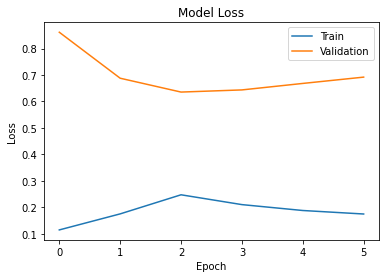

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lossTrain)
plt.plot(lossVal)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

In [ ]:
_, predictions, true_vals = evaluate(dataloader_val)
accuracy_per_class(predictions, true_vals)

100%|██████████| 320/320 [00:38<00:00,  8.28it/s]
                                                                       

Class: 0
Accuracy:1302/1902 - 0.6845425867507886 

Class: 1
Accuracy:3953/4487 - 0.8809895252952975 

Class: 2
Accuracy:3162/3827 - 0.8262346485497779 



In [ ]:
import shutil
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/NLP/Project'
!pwd
shutil.copy("BERT_ft_epoch1.model",base_path)
shutil.copy("BERT_ft_epoch4.model",base_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


FileNotFoundError: ignored

In [ ]:

import numpy as np


bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=3)

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# data['OriginalTweet'].fillna(value='', inplace=True)
# sentences=data['OriginalTweet']
# labels=data['Sentiment']

# input_ids=[]
# attention_masks=[]

# for sent in sentences:
#     bert_inp=tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
#     input_ids.append(bert_inp['input_ids'])
#     attention_masks.append(bert_inp['attention_mask'])

# input_ids=np.asarray(input_ids)
# attention_masks=np.array(attention_masks)
# labels=np.array(labels)
# print(labels)
# print(input_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[0 1 1 ... 1 0 2]
[[  101  1998  1998 ...     0     0     0]
 [  101  6040  2831 ...     0     0     0]
 [  101 21887 23350 ...     0     0     0]
 ...
 [  101  2017  2113 ...     0     0     0]
 [  101  2003  2009 ...     0     0     0]
 [  101  2092  2047 ...   102     0     0]]


In [ ]:
# train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.25,shuffle=True)

# print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))
y = tf.keras.utils.to_categorical(data["Sentiment"].values, num_classes=3)

x_train, x_val, y_train, y_val = train_test_split(data['OriginalTweet'], y, test_size=0.25)

In [ ]:
from keras import backend as K

def avg_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def avg_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def avg_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = avg_precision(y_true, y_pred)
    recall = avg_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = bert_preprocess(i)
x = bert_encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
# x = tf.keras.layers.Dense(16, activation='sigmoid', name="FC")(x)
x = tf.keras.layers.Dense(3, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

# print('\nBert Model',model.summary())

# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]#,avg_recall, avg_precision,avg_f1_score
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

# model.compile(loss=loss,optimizer=optimizer,metrics=[metrics],run_eagerly=True)

In [ ]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      avg_recall,
      avg_precision,
      avg_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      mode='min',
                                                      restore_best_weights = True)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=1e-08),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      batch_size=64,
                      validation_data = (x_val, y_val),
                      callbacks = [earlystop_callback])

Epoch 1/20
483/483 [==============================] - 834s 2s/step - loss: 1.0311 - accuracy: 0.4780 - avg_recall: 0.2397 - avg_precision: 0.4168 - avg_f1_score: 0.2974 - val_loss: 0.9624 - val_accuracy: 0.5332 - val_avg_recall: 0.2165 - val_avg_precision: 0.4789 - val_avg_f1_score: 0.2951
Epoch 2/20
483/483 [==============================] - 824s 2s/step - loss: 0.9905 - accuracy: 0.5075 - avg_recall: 0.2678 - avg_precision: 0.4719 - avg_f1_score: 0.3348 - val_loss: 0.9497 - val_accuracy: 0.5404 - val_avg_recall: 0.2810 - val_avg_precision: 0.4641 - val_avg_f1_score: 0.3463
Epoch 3/20
483/483 [==============================] - 824s 2s/step - loss: 0.9770 - accuracy: 0.5188 - avg_recall: 0.2869 - avg_precision: 0.5090 - avg_f1_score: 0.3599 - val_loss: 0.9478 - val_accuracy: 0.5491 - val_avg_recall: 0.2516 - val_avg_precision: 0.5572 - val_avg_f1_score: 0.3431
Epoch 4/20
483/483 [==============================] - 826s 2s/step - loss: 0.9684 - accuracy: 0.5246 - avg_recall: 0.2946 - avg

KeyboardInterrupt: ignored

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

model.save_weights("bertFinalv1.h5")

In [ ]:
# train_inp = np.array([np.array(val) for val in train_inp])
# train_label = np.array([np.array(val) for val in train_label])
# train_mask = np.array([np.array(val) for val in train_mask])

# val_inp = np.array([np.array(val) for val in val_inp])
# val_label = np.array([np.array(val) for val in val_label])
# val_mask = np.array([np.array(val) for val in val_mask])

# base_output = model.bert([ids, mask, token_type_ids])
# model.trainable = True

# earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
#                                                       patience = 1,
#                                                       restore_best_weights = True)
# history=model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=4,verbose = 1,validation_data=([val_inp,val_mask],val_label),callbacks=earlystop_callback)

Epoch 1/4


TypeError: ignored

In [ ]:
# X_train.fillna(value='', inplace=True)
# X_train = np.array([np.array(val) for val in X_train])
# y_train = np.array([np.array(val) for val in y_train])

# X_test.fillna(value='', inplace=True)
# X_test = np.array([np.array(val) for val in X_test])
# y_test = np.array([np.array(val) for val in y_test])

# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
# preprocessed_text = bert_preprocess(text_input)
# outputs = bert_encoder(preprocessed_text)

# l = tf.keras.layers.Dropout(0.5, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# model = tf.keras.Model(inputs=[text_input], outputs = [l])
# model.summary()

# METRICS = [
#       tf.keras.metrics.CategoricalAccuracy('accuracy'),
#       avg_recall,
#       avg_precision,
#       avg_f1_score
#       # tf.keras.metrics.Precision(class_id=1,name='precision_1'),
#       # tf.keras.metrics.Recall(class_id=1,name='recall_1'),
#       # tf.keras.metrics.Precision(class_id=2,name='precision_2'),
#       # tf.keras.metrics.Recall(class_id=2,name='recall_2')
# ]
# print(X_train.shape)
# print(y_train.shape)
# earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
#                                                       patience = 1,
#                                                       restore_best_weights = True)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
#  metrics=METRICS)
# history=model.fit(X_train,y_train, epochs=3, verbose = 1,validation_data = (X_test, y_test))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

KeyboardInterrupt: ignored

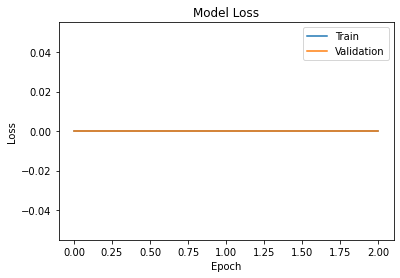

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

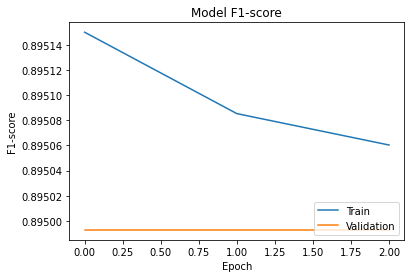

In [ ]:
pd.DataFrame(model.history.history['avg_f1_score']).plot()
plt.plot(model.history.history['val_avg_f1_score'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

In [ ]:
# X_test.fillna(value='', inplace=True)
# X_test = np.array([np.array(val) for val in X_test])
# y_test = np.array([np.array(val) for val in y_test])
# y_predicted = model.predict(X_test)
# y_predicted = y_predicted.flatten()
# y_predicted = np.where(y_predicted > 0.5, 1, 0)
# print(y_predicted)
# model.evaluate(X_test, y_test)

y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
# y_predicted = np.where(y_predicted > 0.5, 0, 1, 2)
print(y_predicted)
model.save_weights("bert.h5")

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
import shutil
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/NLP/Project'
shutil.copy("bertFinalv1.h5",base_path)


Mounted at /content/drive


'/content/drive/My Drive/NLP/Project/bert.h5'

In [ ]:
dataTest = pd.read_csv(r"Corona_NLP_test.csv",encoding='latin-1')
dataTest["Sentiment"] = dataTest["Sentiment"].replace('Extremely Negative', 'Negative', regex=True)

dataTest["Sentiment"] = dataTest["Sentiment"].replace('Extremely Positive', 'Positive', regex=True)

#transform Sentiment to number
#negative=0
#postive=1
#neutral=2
dataTest["Sentiment"]=dataTest["Sentiment"].replace('Negative', 2, regex=True)
dataTest["Sentiment"]=dataTest["Sentiment"].replace('Positive', 1, regex=True)
dataTest["Sentiment"]=dataTest["Sentiment"].replace('Neutral', 0, regex=True)

dataTest["OriginalTweet"] = dataTest["OriginalTweet"].apply(lambda x: lookup_dict(x,emoticons))

dataTest['OriginalTweet']=dataTest['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict1))
dataTest['OriginalTweet']=dataTest['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))
dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.lower()
dataTest['OriginalTweet']=dataTest['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))
dataTest['OriginalTweet'] = dataTest['OriginalTweet'].apply(lambda x: ''.join(''.join(s)[:2] for _, s in itertools.groupby(x)))


#to lower case
dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.lower()
#remove numbers
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('[0-9]', '', regex=True)

#remove mentions
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('@([a-zA-Z0-9_]{1,50})', '', regex=True)

#remove hashtags
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('#', '', regex=True)

#remove urls
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('http\S+', '', regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("_", "", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("   ", " ", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("  ", " ", regex=True)
dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.strip()

dataTest['OriginalTweet'].fillna(value='', inplace=True)
X = np.array([np.array(val) for val in dataTest['OriginalTweet']])


In [ ]:
from sklearn import  metrics
y_predicted = model.predict(X)
y_predicted = y_predicted.flatten()
# print(metrics.classification_report(y_predicted,dataTest["Sentiment"]))
# y_predicted = np.where(y_predicted > 0.5, 0, 1, 2)
print(y_predicted)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
for i in y_predicted:
  if i == 2: 
    print(i)
  elif i==0:
    print(i)

In [ ]:
Y = data["Sentiment"]
# data = data.drop("Sentiment", axis=1, inplace=True)


dataframe = data.copy()
labels = tf.squeeze(tf.constant([dataframe.pop('Sentiment')]), axis=0)

ds = tf.data.Dataset.from_tensor_slices((dataframe["OriginalTweet"].values, labels))#.batch(len(data))

# dataset = tf.data.Dataset.from_tensor_slices(data.values)
train_size = int(0.75 * len(data))
val_size = int(0.25 * len(data))


# # full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
full_dataset = ds.shuffle(buffer_size=len(data))
train_dataset = full_dataset.take(train_size)
# # test_dataset = dataset.skip(train_size)
val_dataset = train_dataset.skip(val_size)
# val_dataset = val_dataset.take(val_size)
# # test_dataset = test_dataset.take(test_size)
# # train_dataset, test_dataset = dataset.train_test_split(split_fraction=0.75)
print(len(train_dataset))
# print(train_feat)
for idx in range(len(train_dataset)):
    for i in train_dataset.take(idx):
        print(idx)
        train_feat = i[0].numpy()
        train_lab = i[1].numpy()
        break

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.head()

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844


In [ ]:
print(len(val_dataset))
for idx in range(len(val_dataset)):
  for j in val_dataset.take(idx):
      val_feat = j[0].numpy()
      val_lab = j[1].numpy()
      break

val = pd.DataFrame([val_feat, val_lab]).T
val.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
val['DATA_COLUMN'] = val['DATA_COLUMN'].str.decode("utf-8")
val.head()

20578


,DATA_COLUMN,LABEL_COLUMN
0,score!! \r\r\n\r\r\ntoiletpaper toiletpapercri...,0


In [ ]:
# integer encode
from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()

def convert_data_to_examples(train, val, DATA_COLUMN, LABEL_COLUMN):
  # integer_encoded = label_encoder.fit_transform(train[LABEL_COLUMN]) 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = val.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  print(train_InputExamples)
  return train_InputExamples, validation_InputExamples

# train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
#                                                                            val, 
#                                                                            'DATA_COLUMN', 
#                                                                            'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, val, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
print(train_data)
train_data = train_data.shuffle(100).batch(16).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(16)

0    InputExample(guid=None, text_a='so much about ...
dtype: object
<FlatMapDataset element_spec=({'input_ids': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int64, name=None))>


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(train_data.batch(16))
model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=3, verbose = 1, validation_data=validation_data)

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>
Epoch 1/3


InvalidArgumentError: ignored

In [ ]:
# tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
# tf_outputs = model(tf_batch)
# tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
# labels = ['Negative','Positive']
# label = tf.argmax(tf_predictions, axis=1)
# label = label.numpy()
# for i in range(len(pred_sentences)):
#   print(pred_sentences[i], ": \n", labels[label[i]])